# Importing Libraries


In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import warnings
%matplotlib inline
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from itertools import product


# Settings


In [88]:
warnings.filterwarnings('ignore')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Preprocessing Text

In [89]:
STEMMER = PorterStemmer()
STOP_WORDS = set(stopwords.words('english'))
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    tokens = text.split()
    tokens = [STEMMER.stem(word) for word in tokens if word not in STOP_WORDS]
    return ' '.join(tokens)

# Loading Dataset


In [90]:
COLUMN_NAMES = ['id', 'topic', 'sentiment', 'text']
df_twitter = pd.read_csv('C:/Users/PC/Desktop/Prodigy_Infotech_Data_Science_Internship/sentiment_analysis/dataset/twitter_training.csv', names=COLUMN_NAMES)


# Preprocessing


In [91]:
df_twitter.dropna(inplace=True)
df_twitter['preprocessed_text'] = df_twitter['text'].apply(preprocess_text)
df_twitter[['text', 'preprocessed_text']].head()

,text,preprocessed_text
0,im getting on borderlands and i will murder yo...,im get borderland murder
1,I am coming to the borders and I will kill you...,come border kill
2,im getting on borderlands and i will kill you ...,im get borderland kill
3,im coming on borderlands and i will murder you...,im come borderland murder
4,im getting on borderlands 2 and i will murder ...,im get borderland murder


# Vectorization


In [92]:
VECTORIZE_MAX_FEATURES = 5000
vectorizer = TfidfVectorizer(max_features=VECTORIZE_MAX_FEATURES)
X_features = vectorizer.fit_transform(df_twitter['preprocessed_text'])
y_labels = df_twitter['sentiment']

# Splitting Data


In [93]:
RANDOM_STATE = 42
TEST_SIZE = 0.3
X_train, X_val, y_train, y_val = train_test_split(X_features, y_labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# Model Training


In [94]:
model = RandomForestClassifier(random_state=RANDOM_STATE)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Predictions


In [95]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Evaluation


In [96]:
print("Train accuracy:")
print(accuracy_score(y_train, y_train_pred))
print("Validation accuracy:")
print(accuracy_score(y_val, y_val_pred))

Train accuracy:
0.9654999324285191
Validation accuracy:
0.8702644263255102


# Confusion Matrix


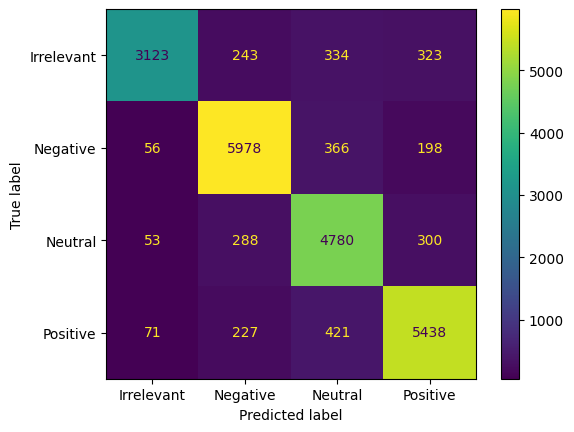

In [97]:
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)

# Hyperparameter Tuning

In [99]:
n_estimators = [100, 200, 300]
max_features = ['sqrt', 'log2']
max_depth = [None, 10, 20, 30]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

best_score = 0
best_params = {}

for est, feat, depth, split, leaf, boot in product(n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap):
    model = RandomForestClassifier(
        n_estimators=est, 
        max_features=feat, 
        max_depth=depth, 
        min_samples_split=split, 
        min_samples_leaf=leaf, 
        bootstrap=boot, 
        random_state=RANDOM_STATE
    )
    
    model.fit(X_train, y_train)
    
    y_val_pred = model.predict(X_val)
    score = accuracy_score(y_val, y_val_pred)
    
    if score > best_score:
        best_score = score
        best_params = {
            'n_estimators': est,
            'max_features': feat,
            'max_depth': depth,
            'min_samples_split': split,
            'min_samples_leaf': leaf,
            'bootstrap': boot
        }

print("Best parameters found: ", best_params)
print("Best validation accuracy: ", best_score)

Best parameters found:  {'n_estimators': 300, 'max_features': 'log2', 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False}
Best validation accuracy:  0.9094103337988197


# Final Model & Metrices

Train accuracy:
0.9654999324285191
Validation accuracy:
0.9094103337988197


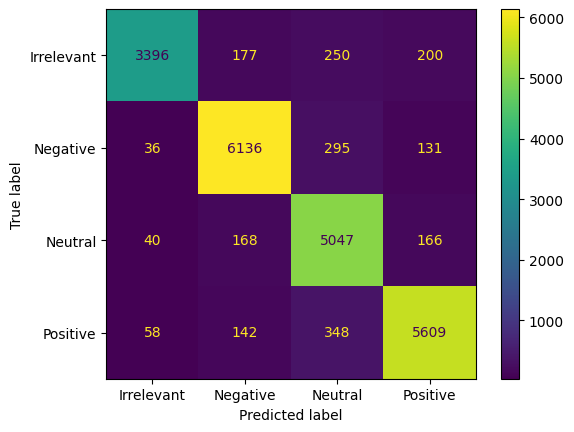

In [100]:
best_model = RandomForestClassifier(**best_params, random_state=RANDOM_STATE)
best_model.fit(X_train, y_train)

y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)

print("Train accuracy:")
print(accuracy_score(y_train, y_train_pred))
print("Validation accuracy:")
print(accuracy_score(y_val, y_val_pred))

ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)
plt.show()


# Performance on the Test Set

Test accuracy:
0.961


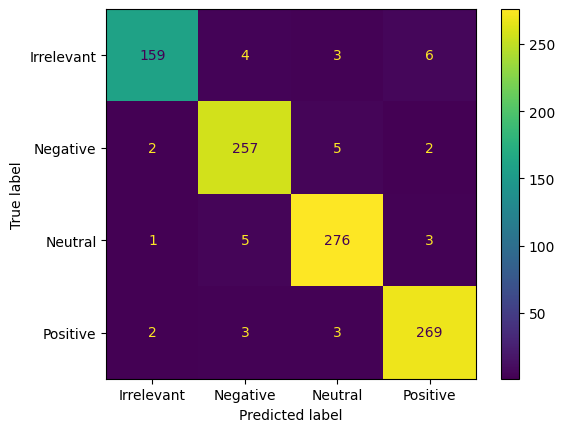

In [101]:
df_test = pd.read_csv('C:/Users/PC/Desktop/Prodigy_Infotech_Data_Science_Internship/sentiment_analysis/dataset/twitter_validation.csv', names=COLUMN_NAMES)

df_test.dropna(inplace=True)
df_test['preprocessed_text'] = df_test['text'].apply(preprocess_text)

X_test_features = vectorizer.transform(df_test['preprocessed_text'])
y_test_labels = df_test['sentiment']

y_test_pred = best_model.predict(X_test_features)

print("Test accuracy:")
print(accuracy_score(y_test_labels, y_test_pred))

ConfusionMatrixDisplay.from_predictions(y_test_labels, y_test_pred)
plt.show()


# Saving the final model info as a text file

In [102]:
output_file_path = 'C:/Users/PC/Desktop/Prodigy_Infotech_Data_Science_Internship/sentiment_analysis/model_performance.txt'

performance_info = f"""
Best parameters found:
{best_params}

Performance:
Train accuracy: {accuracy_score(y_train, y_train_pred)}
Validation accuracy: {accuracy_score(y_val, y_val_pred)}
Test accuracy: {accuracy_score(y_test_labels, y_test_pred)}
"""

with open(output_file_path, 'w') as file:
    file.write(performance_info)

print(f"Model performance and parameters have been saved to {output_file_path}")


Model performance and parameters have been saved to C:/Users/PC/Desktop/Prodigy_Infotech_Data_Science_Internship/sentiment_analysis/model_performance.txt
